#Transformer-based Korean-English translation model
[나동빈님의 코드](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_\(German_English\).ipynb) 를 참고하여 한-영 번역 모델을 구현했습니다.  
데이터는 AI Hub의 한국어-영어 병렬 말뭉치 중 1_구어체(1).xlsx 파일을 사용했으며 20만 개의 병렬 데이터로 구성되어 있습니다.
<br><br>
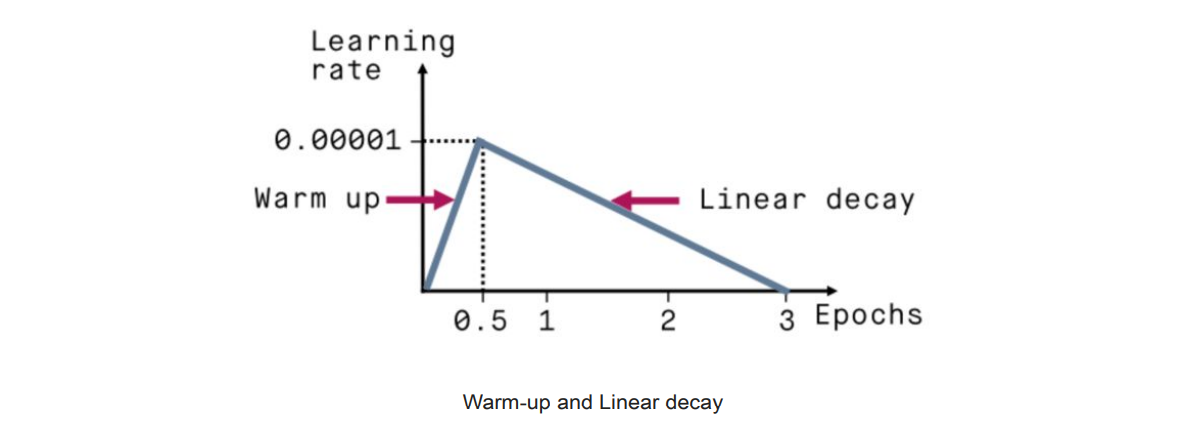
Attention is all you need 논문에서는 Adam Optimizer를 사용했지만 Adam은 Transformer와 같이 일부 깊은 네트워크에서 학습이 어렵다는 단점을 가집니다. 따라서 논문에서는 Warm-up and decay 메커니즘을 함께 적용했습니다. 초기 warm-up 구간에는 Learning Rate를 작게 설정하여 불안정한 모멘텀을 갖는 것을 방지하는 것입니다.
<br><br>
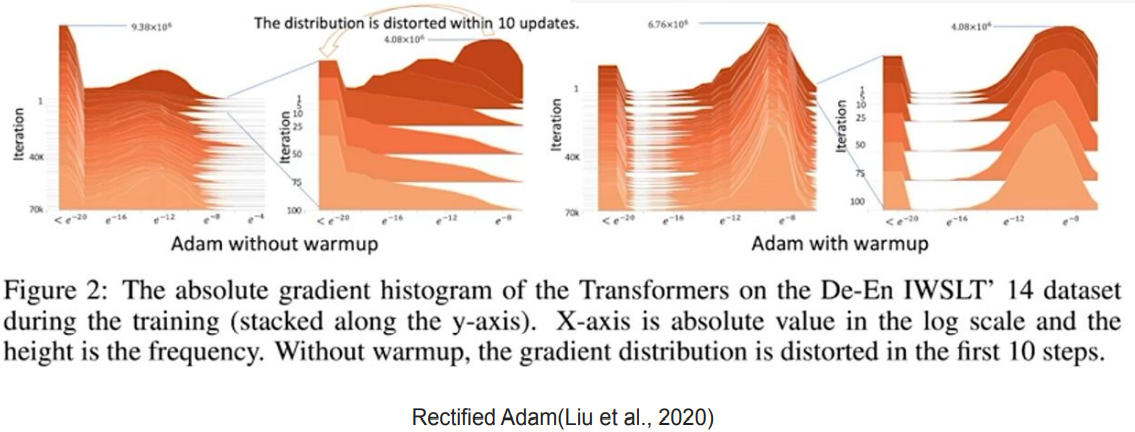
이후에는 Warm-up 구간을 튜닝할 필요 없는 Rectified Adam(Liu et al., 2020)이라는 Optimizer가 제기되었으며, Warm-up and decay 메커니즘조차 필요없이 Normalization 위치만 변경하는 방법론이 On Layer Normalization in the Transformer Architecture (Xiong et al., 2020)에서 제기되었습니다.
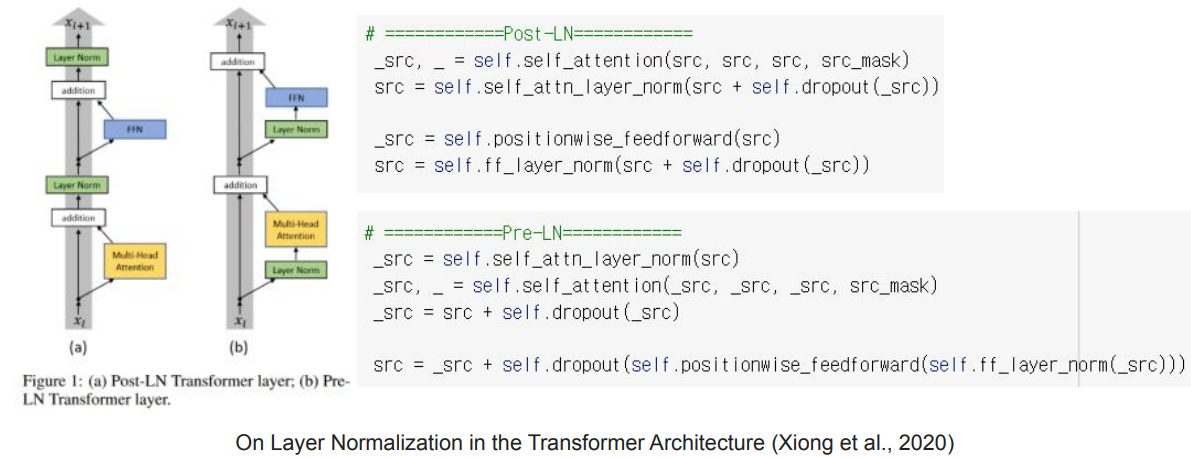
<br><br>
따라서 본 코드에서는 Post-LN + Adam, Post-LN + RAdam, Pre-LN + Adam 3가지의 성능을 비교하는 실험을 진행했습니다.


In [ ]:
# google drive 마운트
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd

Mounted at /content/drive


torchtext.legacy를 사용하기 위해 낮은 버전을 임포트 했습니다.  
https://pypi.org/project/torchtext/ 에서 호환되는 torch와 torchtext의 버전을 확인할 수 있습니다.

In [ ]:
!pip install torch==1.8.1
!pip install torchtext==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 6.2 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 1.8.1 which is incompatible.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.8.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 13.4 MB/s 
  Attempting uninstall: torchtext
    Found existing instal

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://archive.ubuntu.co

#데이터 전처리

전처리 과정은 Subword Segmentation없이 토큰화만 진행했습니다.  
한국어는 Mecab, 영어는 Spacy를 사용했습니다.

In [ ]:
file = pd.read_excel('/content/drive/My Drive/data/1_구어체(1).xlsx')
dataFrame = pd.DataFrame({"kor" : file['원문'], "eng" : file['번역문']})
dataFrame = dataFrame.sample(frac=1).reset_index(drop=True) #데이터 셔플
corpus = dataFrame[:50000]

print(len(corpus))

50000


In [ ]:
corpus.head()

,kor,eng
0,그러고 팀은 아버지의 죽음을 인정하고 삶에 대해 다시 생각하게 됩니다.,"Then, TI'm accepts his fathers death and think..."
1,우리는 고품질의 논문을 제출하실 것을 믿습니다.,We believe that you will submit a paper of hig...
2,AT2356의 개발단축이 필요합니다.,It is necessary to shorten the period of AT235...
3,따라서 전역 연기자를 채용하는 것은 그들의 주장에 좋은 근거가 될 수 있습니다.,So hiring people delaying the retiring of the ...
4,강화도에서 도보여행을 하고 싶은데 준비해야 할 것이 있나요?,"I'd like to go tracking in Gangwhado, is there..."


In [ ]:
from sklearn.model_selection import train_test_split

# Train, Valid, Test 8:1:1 비율로 나누기

train, test = train_test_split(corpus, test_size = 0.2)
valid, test = train_test_split(test, test_size = 0.5)

print("train size: ", len(train))
print("valid size: ", len(valid))
print("test size: ", len(test))

train.to_csv("/content/drive/My Drive/data/train.csv", encoding='utf-8', index = False)
valid.to_csv("/content/drive/My Drive/data/valid.csv", encoding='utf-8', index = False)
test.to_csv("/content/drive/My Drive/data/test.csv", encoding='utf-8', index = False)

train size:  40000
valid size:  5000
test size:  5000


In [ ]:
import spacy
from konlpy.tag import Mecab
tokenizer = Mecab()

spacy_en = spacy.load('en_core_web_sm')

def tokenize_ko(text):
    return [token for token in tokenizer.morphs(text)]

def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [ ]:
from torchtext.legacy import data

SRC = data.Field(tokenize = tokenize_ko, lower = True, batch_first=True)
TRG = data.Field(tokenize = tokenize_en, init_token = "<sos>", eos_token = "<eos>", lower = True, batch_first=True)

train_dataset, valid_dataset, test_dataset = data.TabularDataset.splits(
    path='/content/drive/My Drive/data/',
    train='train.csv', validation='valid.csv', test='test.csv',
    format='csv',
    fields=([('SRC', SRC), ('TRG', TRG)]),
    skip_header=True
)

In [ ]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

print(vars(train_dataset.examples[30])['SRC'])
print(vars(train_dataset.examples[30])['TRG'])

학습 데이터셋(training dataset) 크기: 40000개
평가 데이터셋(validation dataset) 크기: 5000개
테스트 데이터셋(testing dataset) 크기: 5000개
['내', '가', '일정', '이', '정해', '지', '는', '대로', '추후', '다시', '연락', '하', '겠', '다', '.']
['i', "'ll", 'contact', 'you', 'later', 'as', 'soon', 'as', 'my', 'schedule', 'is', 'set', '.']


In [ ]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 11664
len(TRG): 9937


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    sort=False,
    batch_size=BATCH_SIZE,
    device=device)


#Multi-Head Attention

In [ ]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

#Feed-Foward

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

#Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]


        # ============Post-LN============
         _src, _ = self.self_attention(src, src, src, src_mask)
         src = self.self_attn_layer_norm(src + self.dropout(_src))

         _src = self.positionwise_feedforward(src)
         src = self.ff_layer_norm(src + self.dropout(_src))

        # ============Pre-LN============
         #_src = self.self_attn_layer_norm(src)
         #_src, _ = self.self_attention(_src, _src, _src, src_mask)
         #_src = src + self.dropout(_src)

         #src = _src + self.dropout(self.positionwise_feedforward(self.ff_layer_norm(_src)))

         return src

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 forward 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

#Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]


        # self attention

        # ============Post-LN============
         _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
         trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # ============Pre-LN============
         #_trg = self.self_attn_layer_norm(trg)
         #_trg, _ = self.self_attention(_trg, _trg, _trg, trg_mask)
         #trg = trg + self.dropout(_trg)


        # encoder attention

        # ============Post-LN============
         _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
         trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

         _trg = self.positionwise_feedforward(trg)
         trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # ============Pre-LN============
         #normed_enc_src = self.enc_attn_layer_norm(enc_src)
         #_trg, attention = self.encoder_attention(self.enc_attn_layer_norm(trg), normed_enc_src, normed_enc_src, src_mask)
         #trg = trg + self.dropout(_trg)

         #trg = trg + self.dropout(self.positionwise_feedforward(self.ff_layer_norm(trg)))

         return trg, attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

#Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의  토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

#Train

과적합이 발생하여 Dropout은 0.5로 조정하였습니다.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 12,088,529 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(11664, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
        )


In [ ]:
!pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 530 kB/s 


Optimizer를 Adam과 RAdam 2가지를 사용합니다.

In [ ]:
LEARNING_RATE = 0.0005

# ============Adam============
#import torch.optim as optim
#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ============RAdam============
import torch_optimizer as optim # torch 1.13버전 부터는 RAdam이 탑재되나 현재 버전은 1.8이므로 별도로 import
optimizer = optim.RAdam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.SRC
        trg = batch.TRG

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스()는 제외
        # 입력을 할 때는 부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0()은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.SRC
            trg = batch.TRG

            # 출력 단어의 마지막 인덱스()는 제외
            # 입력을 할 때는 부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0()은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_korean_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 37s
	Train Loss: 7.019 | Train PPL: 1117.994
	Validation Loss: 6.010 | Validation PPL: 407.651
Epoch: 02 | Time: 0m 31s
	Train Loss: 5.721 | Train PPL: 305.277
	Validation Loss: 5.257 | Validation PPL: 191.907
Epoch: 03 | Time: 0m 31s
	Train Loss: 5.136 | Train PPL: 170.103
	Validation Loss: 4.906 | Validation PPL: 135.068
Epoch: 04 | Time: 0m 32s
	Train Loss: 4.829 | Train PPL: 125.106
	Validation Loss: 4.639 | Validation PPL: 103.473
Epoch: 05 | Time: 0m 31s
	Train Loss: 4.606 | Train PPL: 100.064
	Validation Loss: 4.452 | Validation PPL: 85.826
Epoch: 06 | Time: 0m 32s
	Train Loss: 4.427 | Train PPL: 83.683
	Validation Loss: 4.322 | Validation PPL: 75.315
Epoch: 07 | Time: 0m 31s
	Train Loss: 4.278 | Train PPL: 72.117
	Validation Loss: 4.200 | Validation PPL: 66.717
Epoch: 08 | Time: 0m 32s
	Train Loss: 4.140 | Train PPL: 62.830
	Validation Loss: 4.101 | Validation PPL: 60.381
Epoch: 09 | Time: 0m 32s
	Train Loss: 4.019 | Train PPL: 55.637
	Validation Loss: 4.05

In [ ]:
model.load_state_dict(torch.load('transformer_korean_to_english.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 3.984 | Test PPL: 53.708


#BLEU
번역 모델에서는 성능 평가 지표로 BLEU 스코어를 사용합니다. 낮은 Perplexity가 좋은 번역 품질을 보장하지 못하기 때문입니다. 특히 한국어는 교착어에 속하기 때문에 어순이 바뀌어도 무방하지만 Perplexity 값은 달라지게 됩니다. 따라서 N-gram을 활용한 BLEU 스코어를 활용하는데 corpus_bleu(trgs, pred_trgs, weights=(1, 0, 0, 0)) 함수에서 weights 첫 번째 값을 1로 두면 unigram을 사용한다는 뜻입니다. 표준은 0.25,0.25,0.25,0.25 로 가중치를 1-gram, 2-gram, 3-gram, 4-gram 동일하게 두는 값을 사용합니다.

In [ ]:
# 번역(translation) 함수
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = Mecab()
        tokens = [token.lower() for token in nlp.morphs(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에  토큰, 마지막에  토큰 붙이기
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는  토큰 하나만 가지고 있도록 하기
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # 를 만나는 순간 끝
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    # 첫 번째 는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def show_bleu(data, src_field, trg_field, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in data:
        src = vars(datum)['SRC']
        trg = vars(datum)['TRG']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len, logging=False)

        # 마지막  토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    score1 = corpus_bleu(trgs, pred_trgs, weights=(1, 0, 0, 0))
    print(f'1-gram BLEU Score = {score1*100:.2f}')

    score2 = corpus_bleu(trgs, pred_trgs, weights=(0, 1, 0, 0))
    print(f'2-gram BLEU Score = {score2*100:.2f}')

    score3 = corpus_bleu(trgs, pred_trgs, weights=(0.25, 0.25, 0.25, 0.25))
    print(f'Standard BLEU Score = {score3*100:.2f}')



In [ ]:
show_bleu(test_dataset, SRC, TRG, model, device)


[100/5000]
예측: ['i', 'am', 'sending', 'the', 'final', 'information', 'about', 'the', 'company', '.']
정답: ['we', 'try', 'to', 'improve', 'the', 'plan', '.']
[200/5000]
예측: ['i', 'want', 'to', 'get', 'a', '<unk>', 'and', '<unk>', '.']
정답: ['i', 'received', 'a', 'try', 'of', 'eggs', 'right', 'now', '.']
[300/5000]
예측: ['please', 'send', 'me', 'the', 'invoice', 'you', 'to', 'the', 'invoice', '.']
정답: ['please', 'figure', 'out', 'where', 'the', 'package', 'is', 'and', 'let', 'me', 'know', '.']
[400/5000]
예측: ['i', 'want', 'to', 'know', 'how', 'to', 'go', 'to', 'the', 'philippines', ',', 'but', 'i', 'want', 'to', 'the', 'philippines', '.']
정답: ['if', 'you', 'were', 'being', 'nice', 'to', 'me', 'because', 'you', 'wanted', 'to', 'come', 'to', 'my', 'house', 'and', 'stay', 'with', 'me', ',', 'i', 'do', 'n’t', 'need', 'to', 'receive', 'that', '.']
[500/5000]
예측: ['i', "'m", 'so', 'tired', 'of', 'my', 'friend', 'who', 'loves', 'you', '.']
정답: ['please', 'tell', 'yana', 'that', 'dad', 'loves', 'he

#실험 결과
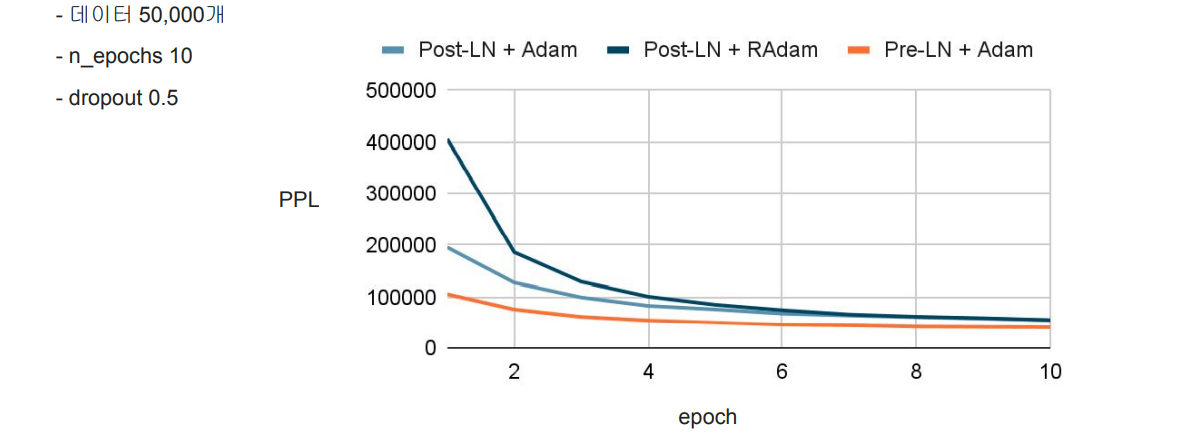

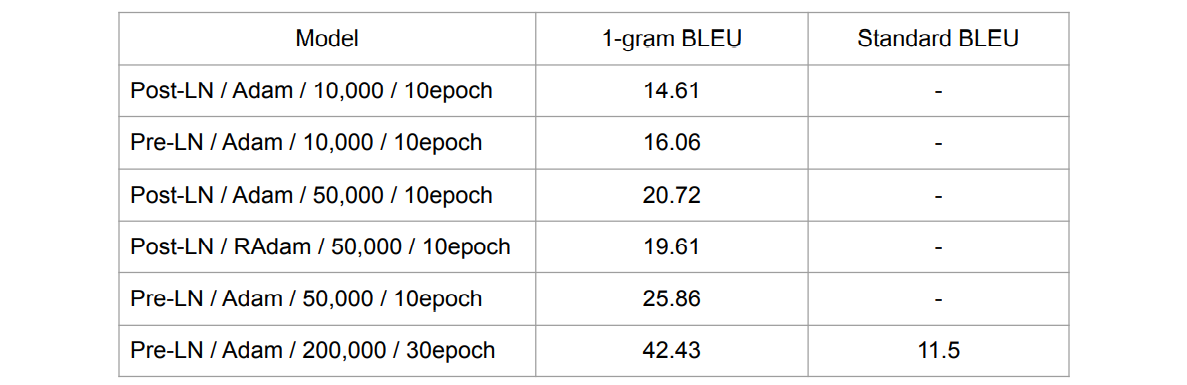

Attention is all you need 논문에서의 번역기 성능은 20후반대 이상을 기록했다. 50,000개 이하의 데이터를 사용할 때는 표준 BLEU 값을 계산하는 것이 무의미할 정도로 낮은 점수를 기록했으며 20만 개 이상부터 유의미한 값이 산출되었다. Layer Norm의 위치를 바꾸는 것만으로 성능이 크게 향상되었으며 RAdam을 사용할 때는 기대와 달리 큰 성능 향상은 없었다.